In [1]:
import numpy as np
import xarray as xr
import pyremo as pr
import cmaps
import glob
import xesmf as xe
from REMO2020_mod import modelclass, CLARA_albedo_open_process, cal_mon_mean, get_domain, open_mfdataset, domainclass, plotclass, clara_plotter_mon

ERROR 1: PROJ: proj_create_from_database: Open of /work/ch0636/g300096/Python/envs/kernelR2020/share/proj failed


In [2]:
from dask.distributed import Client, progress
import dask
dask.config.set({'temporary_directory': '/scratch/g/g300096/dask/tmp'})
client = Client()
client

/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43829 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/g300096/levante-spawner-preset//proxy/43829/status,
Dashboard: /user/g300096/levante-spawner-preset//proxy/43829/status,Workers: 16
Total threads: 256,Total memory: 486.93 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43087,Workers: 16
Dashboard: /user/g300096/levante-spawner-preset//proxy/43829/status,Total threads: 256
Started: Just now,Total memory: 486.93 GiB
Comm: tcp://127.0.0.1:46699,Total threads: 16
Dashboard: /user/g300096/levante-spawner-preset//proxy/35045/status,Memory: 30.43 GiB
Nanny: tcp://127.0.0.1:43813,


In [3]:
# define the runs to be plotted
modelruns =[] # init

modelruns.append(modelclass("056524","REMO2015",False))
modelruns.append(modelclass("036030","REMO2020$_{27}$",True))
modelruns.append(modelclass("036032","REMO2020$_{49}$",True))
modelruns.append(modelclass("036039","REMO2020$_{49}$ iMOVE",True))

In [4]:
# give suffix (the main name for the plots)
figpath = './figures/'
prefix = 'CLARAv3_alb_mon_'
suffix = 'REMO2020_2749_main'

In [5]:
# define star year and end year
ystart=2001
yend=2010

In [6]:
# REMO and EOBS datapath
rdata = './data_in/model_data/'
claradata = './data_in/CLARA/'

In [7]:
# Cut global clara to these coordinates (choose them so that the remo domain is within)
min_lon = -50.0
min_lat = 20.0 
max_lon = 70.0 
max_lat = 76.0

In [8]:
# Define the order of seasons to be used (also when plotting)
months = ["February","March","April","May"]

In [9]:
# prepare clara data
dsclaramon = CLARA_albedo_open_process(claradata,months,ystart,yend,min_lat,max_lat,min_lon,max_lon)

In [10]:
yearlist = np.arange(ystart,yend+1)
for obj in modelruns:
    for year in yearlist:
        pattern = rdata+"remo_results_"+obj.userexp+"/"+str(year)+"/e"+obj.userexp+"m*.nc"
        obj.filenames += glob.glob(pattern)
    obj.filenames.sort()

In [11]:
# Target grid
trggrid = "EUR-11"
target_grid = get_domain(trggrid)

In [12]:
# Set halo zone length (will be cutted out)
halo = 8

In [13]:
# for regriddder, we need haloless data
target_grid = target_grid.isel(rlat=slice(halo+1,target_grid.sizes["rlat"]-halo+1), rlon=slice(halo+1,target_grid.sizes["rlon"]-halo+1))

In [14]:
# prepare regridder to regrid REMO data to clara (0.11 -> 0.25)
regridder = xe.Regridder(target_grid, dsclaramon, "bilinear")

/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


In [15]:
# calculate the albedo difference to CLARA
for obj in modelruns:
    ds = open_mfdataset(obj.filenames, parallel=False, chunks='auto')
    REMOvar = pr.parse_dates(ds[["ALBEDO"]])
    # make mean for specific months (basically here just pick months)
    REMOmon = cal_mon_mean(REMOvar,months)
    # cut halo
    REMOmon = REMOmon.isel(rlat=slice(halo+1,REMOmon.sizes["rlat"]-halo+1), rlon=slice(halo+1,REMOmon.sizes["rlon"]-halo+1)).compute()
    #
    CC_clgrid = regridder(REMOmon)
    # Merge data (get identical coordinates)
    CC_all = xr.merge([CC_clgrid, dsclaramon], compat="override", join="override")
    # substract the values, finally making seasonal means
    obj.vardiff = (CC_all.ALBEDO-CC_all.clavar).where(CC_all.ALBEDO > 0,drop=True).squeeze().compute()
    # not supported, set to zero
    obj.mask = np.zeros(len(months))
    if(obj.r2020file):
        pole = (ds.rotated_latitude_longitude.grid_north_pole_longitude,ds.rotated_latitude_longitude.grid_north_pole_latitude)

In [16]:
# mask absolute values based on model data (here based on the last model data, but as we use ">=" we basically mask only the whole REMO grid)
dsclaramon = dsclaramon.where(CC_all.ALBEDO > 0,drop=True).squeeze()

In [17]:
# define the domains to be plotted
domaininfo =[] # init
domaininfo.append(domainclass("NEU",[2,54,45,73], hspace=0.35, ylocs=range(-90,90,5)))

In [18]:
# define plotclasses for absolute and difference (model) plots
absplotc = plotclass(label='Albedo', lspace=np.linspace(0,1,32), vmin=0, vmax=0.8, linvert=False, cmapp=cmaps.BlAqGrYeOrReVi200)
modplotc = plotclass(label='$\Delta$Albedo', lspace=np.linspace(0,1,12), vmin=-0.3, vmax=0.3, linvert=False, cmapp=cmaps.BlueWhiteOrangeRed)

/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/work/ch0636/g300096/Python/envs/kernelR2020/lib/python3.10/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecate

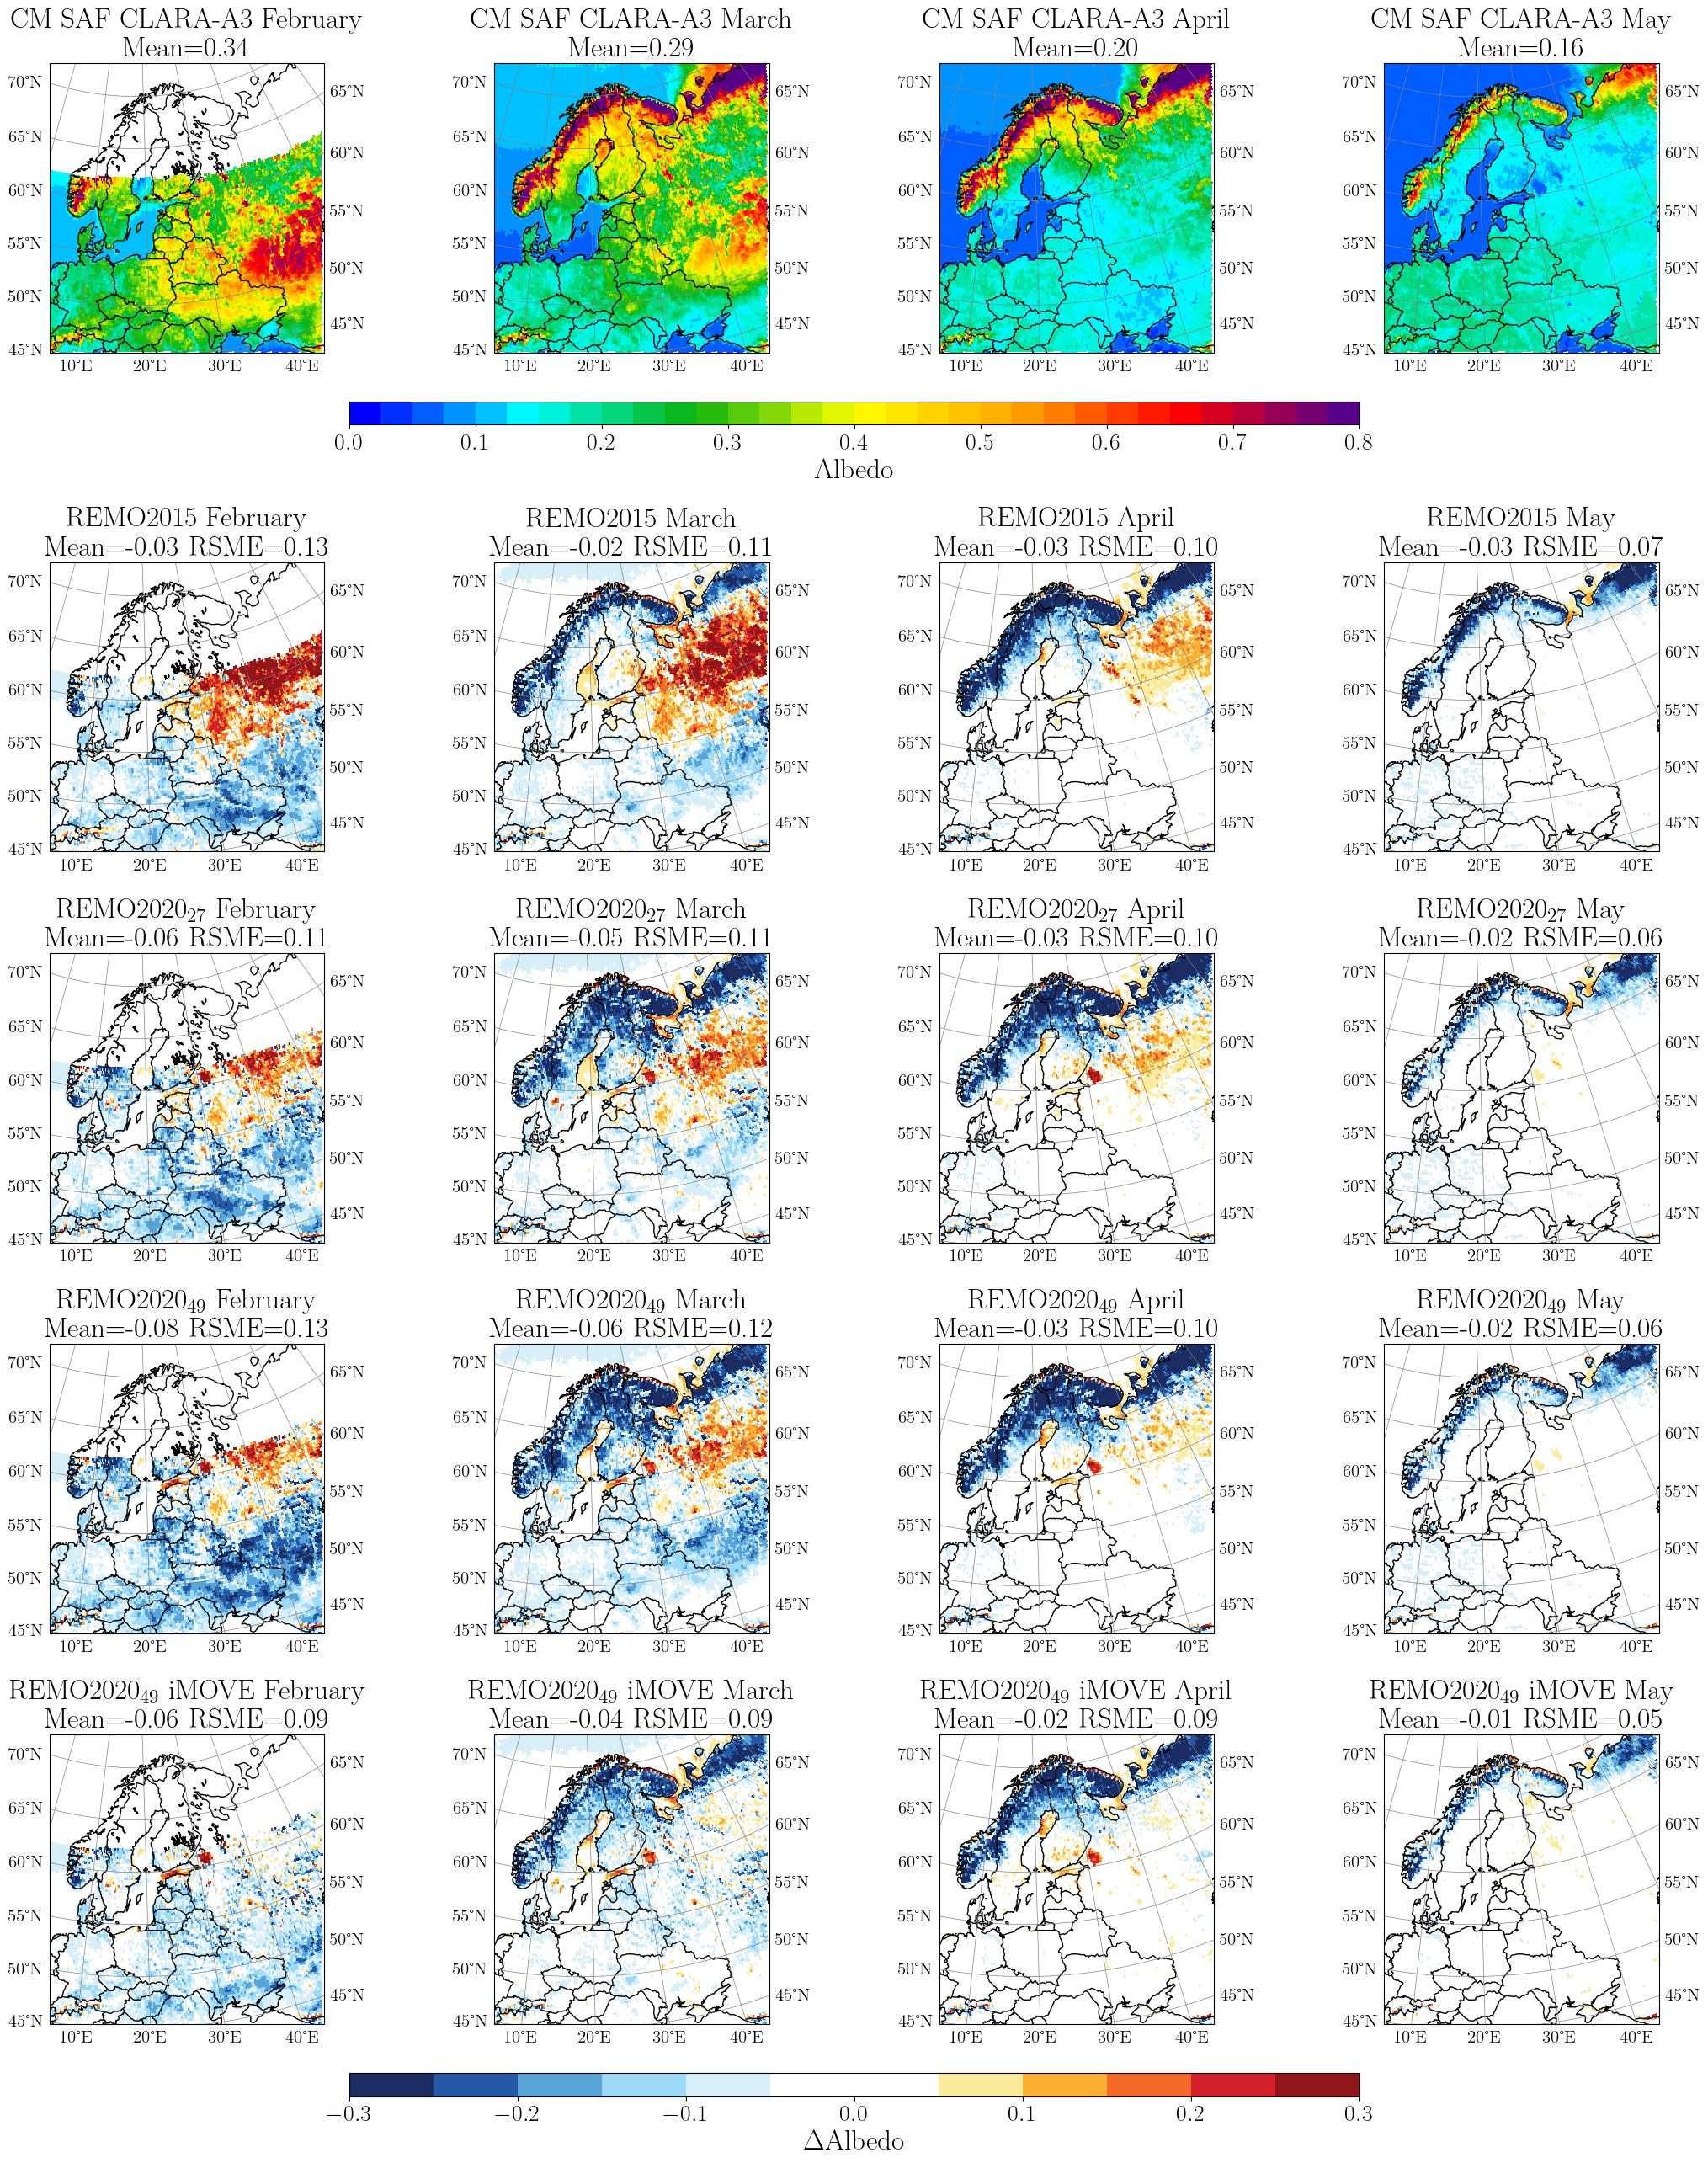

In [19]:
# Loop over domains
for dom in range(len(domaininfo)):
    # Create figure name
    figname=prefix+domaininfo[dom].name+'_'+suffix
    # Call plotter (we can use the eobs plotter directly)
    clara_plotter_mon(absplotc,modplotc,domaininfo[dom],pole,modelruns,"CM SAF CLARA-A3",dsclaramon.clavar,months,False,figpath,figname)